## Задача проекта:

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг:

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Структура проекта:

* [Загрузка данных](#section_1)
* [Общая информация](#section_2)
* [Подготовка данных](#section_3)
* [Соединие таблиц](#section_4)
* [Исследовательский анализ данных](#section_5)
* [Проверка гипотез](#section_6)
* [Подготовка данных к машинному обучению](#section_7)
* [Модели машинного обучения](#section_8)
* [Выводы](#section_9)

<a id='section_1'></a>

### Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
contract = pd.read_csv('/content/gdrive/MyDrive/data/final_provider/contract.csv')
personal = pd.read_csv('/content/gdrive/MyDrive/data/final_provider/personal.csv')
internet = pd.read_csv('/content/gdrive/MyDrive/data/final_provider/internet.csv')
phone = pd.read_csv('/content/gdrive/MyDrive/data/final_provider/phone.csv')

### Общая информация

In [5]:
def info(data):
    display(data.head())
    display(data.shape)
    display(data.info())
    display(data.describe())
    display(print('Дубликаты: ', data.duplicated().sum()))
    for x in data.columns:
        print(data[x].unique())

In [6]:
print('Общие данные по "contract"')
info(contract)

Общие данные по "contract"


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


(7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Дубликаты:  0


None

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '201

In [7]:
contract["customerID"].duplicated().sum()

0

In [8]:
print('Общие данные по "personal"')
info(personal)

Общие данные по "personal"


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


(7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Дубликаты:  0


None

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


In [9]:
personal["customerID"].duplicated().sum()

0

In [10]:
print('Общие данные по "internet"')
info(internet)

Общие данные по "internet"


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


(5517, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Дубликаты:  0


None

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


In [11]:
internet["customerID"].duplicated().sum()

0

In [12]:
print('Общая информация по "phone"')
info(phone)

Общая информация по "phone"


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


(6361, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Дубликаты:  0


None

['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
['No' 'Yes']


In [13]:
phone["customerID"].duplicated().sum()

0

Выводы:

contract

* Всего контрактов 7043 штук
* нулевых значений нет
* Дубликатов нет
* BeginDateye нужно перевести в date
* TotalCharges - float64

сделать после объединения таблиц:
* BeginDate - оставить только день, иначе модель может переобучиться
* Type - преобразовать категориальный признак в численный
* PaperlessBilling - преобразовать категориальный признак в численный
* PaymentMethod - преобразовать категориальный признак в численный
* EndDate - преобразовать в бинарный признак

personal
* Всего клиентов 7043
* Нулевых данных нет
* Дубликатов нет
* После объединения таблиц данные по столбцам gender, Partner, Dependents нужно преобразовать в численный


internet
* Всего клиентов пользуются услугами интернета 5517
* Нулевых данных нет
* Дубликатов нет
* После объединения все столбцы кроме customerID преобразуем категориальный признак в численный

phone
* Всего клиентов пользуются услугами телефона 6361
* Нулевых данных нет
* Дубликатов нет
* После объединения таблиц MultipleLines преобразовать категориальный признак в численный

<a id='section_3'></a>

### Подготовка данных

In [14]:
contract_df = contract
personal_df = personal
internet_df = internet 
phone_df = phone

In [15]:
contract_df.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85


Преобразуем в нужный тип данных

In [16]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format = '%Y-%m-%d')

Выдели день недели, месяц и год в отдельные столбцы

In [17]:
contract_df['Day'] = contract_df['BeginDate'].dt.day_name()

In [18]:
contract_df['Month'] = contract_df['BeginDate'].dt.month

In [19]:
contract_df['Year'] = contract_df['BeginDate'].dt.year

In [20]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Saturday,4,2017
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Sunday,5,2016
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Sunday,9,2019


Создадим новый столбец даты, в котором укажем крайнюю дату среза вместо "No"

In [21]:
def date(n):
    f = n['EndDate']

    if f == 'No':
        return '2020-02-01 00:00:00'

    else:
        return f
    
contract_df['Date'] = contract_df.apply(date, axis=1)


In [22]:
contract_df['Date'] = pd.to_datetime(contract_df['Date'], format = '%Y-%m-%d')

Создадим столбец жизни клиента в компании

In [23]:
contract_df['DaysInside'] = contract_df['Date'] - contract_df['BeginDate']

In [24]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,Date,DaysInside
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,2020-02-01,31 days
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Saturday,4,2017,2020-02-01,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019,2019-12-01,61 days
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Sunday,5,2016,2020-02-01,1371 days
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Sunday,9,2019,2019-11-01,61 days


Преобразуем в корректный тип данных

In [25]:
contract_df['DaysInside'] = contract_df['DaysInside'].dt.days.astype('int64')

In [26]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,Date,DaysInside
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Saturday,4,2017,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Sunday,5,2016,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Sunday,9,2019,2019-11-01,61


Создадим столбец в которм сконвертируем целевой признак в бинарный

In [27]:
def target(n):
    f = n['EndDate']

    if f == 'No':
        return 1

    else:
        return 0
    
contract_df['target'] = contract_df.apply(target, axis=1)

In [28]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,Date,DaysInside,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,2020-02-01,31,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Saturday,4,2017,2020-02-01,1036,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019,2019-12-01,61,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Sunday,5,2016,2020-02-01,1371,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Sunday,9,2019,2019-11-01,61,0


In [29]:
contract_df = contract_df.drop('BeginDate', axis = 1)
contract_df = contract_df.drop('EndDate', axis = 1)
contract_df = contract_df.drop('Date', axis = 1)
contract_df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,31,1
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.5,Saturday,4,2017,1036,1
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019,61,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Sunday,5,2016,1371,1
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Sunday,9,2019,61,0


In [30]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   Day               7043 non-null   object 
 7   Month             7043 non-null   int64  
 8   Year              7043 non-null   int64  
 9   DaysInside        7043 non-null   int64  
 10  target            7043 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 605.4+ KB


Преобразуем в корректный тип данных

In [31]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'],errors='coerce')

In [32]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Day               7043 non-null   object 
 7   Month             7043 non-null   int64  
 8   Year              7043 non-null   int64  
 9   DaysInside        7043 non-null   int64  
 10  target            7043 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 605.4+ KB


Обнаружены нули в столбце TotalCharges

In [33]:
contract_df['TotalCharges'].isna().sum()

11

In [34]:
contract_df[contract_df['TotalCharges'].isna()]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,Saturday,2,2020,0,1
753,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,Saturday,2,2020,0,1
936,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,Saturday,2,2020,0,1
1082,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,Saturday,2,2020,0,1
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,Saturday,2,2020,0,1
3331,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,Saturday,2,2020,0,1
3826,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,Saturday,2,2020,0,1
4380,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,Saturday,2,2020,0,1
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,Saturday,2,2020,0,1
6670,4075-WKNIU,Two year,No,Mailed check,73.35,NaN,Saturday,2,2020,0,1


In [35]:
contract_df['TotalCharges'].median()

1397.475

Заполним пустые значения нулями, тк это люди, которые только пришли и еще не успели заплатить.

In [36]:
contract_df['TotalCharges']=contract_df['TotalCharges'].fillna(0)                                                             

In [37]:
contract_df['TotalCharges'].isna().sum()

0

<a id='section_4'></a>

### Соединение таблиц

In [38]:
display(contract_df.head(1))
display(personal_df.head(1))
display(internet_df.head(1))
display(phone_df.head(1))

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,31,1


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No


In [39]:
combine = personal_df.merge(contract_df, on=['customerID'], how='outer')
combine = combine.merge(internet_df, on=['customerID'], how='outer')
combine = combine.merge(phone_df, on=['customerID'], how='outer')

In [40]:
print('Длина таблицы после объединения', len(combine))

Длина таблицы после объединения 7043


In [41]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Type              7043 non-null   object 
 6   PaperlessBilling  7043 non-null   object 
 7   PaymentMethod     7043 non-null   object 
 8   MonthlyCharges    7043 non-null   float64
 9   TotalCharges      7043 non-null   float64
 10  Day               7043 non-null   object 
 11  Month             7043 non-null   int64  
 12  Year              7043 non-null   int64  
 13  DaysInside        7043 non-null   int64  
 14  target            7043 non-null   int64  
 15  InternetService   5517 non-null   object 
 16  OnlineSecurity    5517 non-null   object 


После объединения в некоторых колонкаx образовались отсутствующие значения Nan из-за отсутствия той или иной услуги, заполним эти словом "No" . Это будет значить , что услуга у данного абонента не фигурирует.

In [42]:
combine = combine.fillna('No')

Проверим корректность слияния таблицы. Зададим условие, при котором у абонента нет интернета и нет телефонии

In [43]:
len(combine[(combine['InternetService'] == 0) & (combine['MultipleLines'] == 0)])

0

Слияние прошло корректно

<a id='section_5'></a>

### Исследовательский анализ данных

In [44]:
combine.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,31,1,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,Saturday,4,2017,1036,1,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019,61,0,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,Sunday,5,2016,1371,1,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Sunday,9,2019,61,0,Fiber optic,No,No,No,No,No,No,No


Проверим зависимость в оплатах некоторых признаков: Услуга интернет, гендерное разделение, возрастное разделение, наличие детей и метод оплаты.

In [46]:
pivot_1 = combine[combine['InternetService'] != 0].pivot_table(index = 'InternetService', values = 'MonthlyCharges', aggfunc = ['sum', 'count', 'mean']).reset_index()
pivot_1.columns = ['Название_услуги', 'Приносят_в_месяц', 'Кол-во_клиентов', 'Средняя_мес_оплата']
pivot_1['Доля'] = pivot_1['Приносят_в_месяц'] / combine[combine['InternetService'] != 0]['MonthlyCharges'].sum()
display(pivot_1)
fig = px.bar(pivot_1.sort_values('Приносят_в_месяц', ascending = True), x = 'Название_услуги', y = 'Приносят_в_месяц', title='Услуга интернет')
fig.show()

,Название_услуги,Приносят_в_месяц,Кол-во_клиентов,Средняя_мес_оплата,Доля
0,DSL,140665.35,2421,58.102169,0.308398
1,Fiber optic,283284.40,3096,91.500129,0.621079
2,No,32166.85,1526,21.079194,0.070523


Fiber optic используют 62% представленных людей, они же и тратят в месяц больше остальных, в среднем - 91уе

In [47]:
pivot_2 = combine.pivot_table(index = 'gender', values = 'MonthlyCharges', aggfunc = ['sum', 'count', 'mean']).reset_index()
pivot_2.columns = ['Пол', 'Приносят_в_месяц', 'Кол-во_клиентов', 'Средняя_мес_оплата']
pivot_2['Доля'] = pivot_2['Приносят_в_месяц'] / combine['MonthlyCharges'].sum()
display(pivot_2)
fig = px.bar(pivot_2.sort_values('Приносят_в_месяц', ascending = True), x = 'Пол', y = 'Приносят_в_месяц', title='Гендерное разделение')
fig.show()

,Пол,Приносят_в_месяц,Кол-во_клиентов,Средняя_мес_оплата,Доля
0,Female,227432.4,3488,65.204243,0.498628
1,Male,228684.2,3555,64.327482,0.501372


Нам представлен датасет, в котором почти поровну мужчин и женщин.
Интересно то, что в месячной оплате между мужчинами и женщинами нет видимой разницы в данных. Они в среднем одинаково платят в месяц по 65 и 64 уе. Нужно будет это проверить чуть позже.

In [48]:
pivot_3 = combine.pivot_table(index = 'SeniorCitizen', values = 'MonthlyCharges', aggfunc = ['sum', 'count', 'mean']).reset_index()
pivot_3.columns = ['Пенсионный_статус', 'Приносят_в_месяц', 'Кол-во_клиентов', 'Средняя_мес_оплата']
pivot_3['Доля'] = pivot_3['Приносят_в_месяц'] / combine['MonthlyCharges'].sum()
display(pivot_3)
fig = px.bar(pivot_3.sort_values('Приносят_в_месяц', ascending = True), x = 'Пенсионный_статус', y = 'Приносят_в_месяц', 
             title='Возрастное разделение: "0"-Не пенсионер / "1"-Пенсионер')
fig.show()

,Пенсионный_статус,Приносят_в_месяц,Кол-во_клиентов,Средняя_мес_оплата,Доля
0,0,364961.75,5901,61.847441,0.80015
1,1,91154.85,1142,79.820359,0.19985


Пенсионеров в данных почти 20%. Что интересно, в среднем пенсионеры платят больше, чем другие группы людей - около 80 уе. Видимо, это связано с большим количеством услуг, на которые люди соглашаются при подключении и в силу возраста не могут потом отключить. 

In [49]:
pivot_4 = combine.pivot_table(index = 'Dependents', values = 'MonthlyCharges', aggfunc = ['sum', 'count', 'mean']).reset_index()
pivot_4.columns = ['Dependents', 'Приносят_в_месяц', 'Кол-во_клиентов', 'Средняя_мес_оплата']
pivot_4['Доля'] = pivot_4['Приносят_в_месяц'] / combine['MonthlyCharges'].sum()
display(pivot_4)
fig = px.bar(pivot_4.sort_values('Приносят_в_месяц', ascending = True), x = 'Dependents', y = 'Приносят_в_месяц', 
             title='Наличие детей')
fig.show()

,Dependents,Приносят_в_месяц,Кол-во_клиентов,Средняя_мес_оплата,Доля
0,No,330524.85,4933,67.002808,0.72465
1,Yes,125591.75,2110,59.522156,0.27535


Людей, у торорых детей нет, в датасете 72% и платят они в месяц в среднем 67уе. Люди у которых дети есть платят меньше - 59уе. Вероятно, наличие детей налагает свой отпечаток на бюджете семьи и факторе экономии.

In [50]:
pivot_5 = combine.pivot_table(index = 'PaymentMethod', values = 'MonthlyCharges', aggfunc = ['sum', 'count', 'mean']).reset_index()
pivot_5.columns = ['PaymentMethod', 'Приносят_в_месяц', 'Кол-во_клиентов', 'Средняя_мес_оплата']
pivot_5['Доля'] = pivot_5['Приносят_в_месяц'] / combine['MonthlyCharges'].sum()
display(pivot_5)
fig = px.bar(pivot_5.sort_values('Приносят_в_месяц', ascending = True), x = 'PaymentMethod', y = 'Приносят_в_месяц', 
             title='Метод оплаты')
fig.show()

,PaymentMethod,Приносят_в_месяц,Кол-во_клиентов,Средняя_мес_оплата,Доля
0,Bank transfer (automatic),103745.45,1544,67.192649,0.227454
1,Credit card (automatic),101231.85,1522,66.512385,0.221943
2,Electronic check,180345.00,2365,76.255814,0.395392
3,Mailed check,70794.30,1612,43.917060,0.155211


Наибольшее количество людей используют электронный чек при оплате - почти 40%. Они же в среднем платят больше других 76уе в месяц. Может быть эти люди "продвинутее" остальных.

<a id='section_6'></a>

### Проверка гипотез

Спорным моментом в построении таблиц было видимое равенство в месячных платежах клиентов разного пола.
Построим гипотезу доказывающую или отвергающую утверждение: "Средняя месячная оплата мужчин и женщин одинаковы"
За нулевую гипотезу примем то , что они одинаковы, а за альтернативную то, что они отличаются.

In [51]:
combine.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,31,1,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,Saturday,4,2017,1036,1,DSL,Yes,No,Yes,No,No,No,No


In [52]:
men = combine[combine['gender'] == 'Male']
women = combine[combine['gender'] == 'Female']

In [53]:
len(men) + len(women)

7043

In [54]:
print('Средний месячный платеж мужчин: ', men['MonthlyCharges'].mean())
print('Средний месячный платеж у женщин: ', women['MonthlyCharges'].mean())

Средний месячный платеж мужчин:  64.32748241912773
Средний месячный платеж у женщин:  65.20424311926602


In [55]:
sample_1 = men['MonthlyCharges']
sample_2 = women['MonthlyCharges']

alpha = .05 

results = st.ttest_ind(
    sample_1.dropna(), 
    sample_2.dropna(),
    equal_var=True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.22150229932988072
Не получилось отвергнуть нулевую гипотезу


Наши видимые предположения оказались верны. Не вышло опровергнуть нулевую гипотезу о том, что платеж мужчины и женщины одинаковый. Можно сделать заключение, что значимой разницы в гендере клиента нет: что мужчины, что женщины - платят одинаково. Никакой дискриминации!:)

<a id='section_7'></a>

### Подготовка данных к машинному обучению

In [56]:
combine.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,31,1,DSL,No,Yes,No,No,No,No,No


In [57]:
combine = combine.drop(columns=['customerID'])

Создадим временный датафрейм, где преобразуем категориальные признаки и посмотрим на матрицу зависимостей

In [58]:
time = combine.copy()

In [59]:
time.head(3)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,Wednesday,1,2020,31,1,DSL,No,Yes,No,No,No,No,No
1,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,Saturday,4,2017,1036,1,DSL,Yes,No,Yes,No,No,No,No
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Tuesday,10,2019,61,0,DSL,Yes,Yes,No,No,No,No,No


In [60]:
time.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Day', 'Month', 'Year', 'DaysInside', 'target', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [61]:
encoder = OrdinalEncoder()
col = ['gender', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'Day', 
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
       'StreamingTV', 'StreamingMovies', 'MultipleLines']
encoder.fit(time[col])
time[col]=encoder.transform(time[col])

In [62]:
time.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,Month,Year,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0.0,0,1.0,0.0,0.0,1.0,2.0,29.85,29.85,6.0,1,2020,31,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0,0.0,0.0,1.0,0.0,3.0,56.95,1889.50,2.0,4,2017,1036,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0,0.0,0.0,0.0,1.0,3.0,53.85,108.15,5.0,10,2019,61,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0,0.0,0.0,1.0,0.0,0.0,42.30,1840.75,3.0,5,2016,1371,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,1.0,2.0,70.70,151.65,3.0,9,2019,61,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построим корреляцию Спирмена/Пирсона для количественных шкал

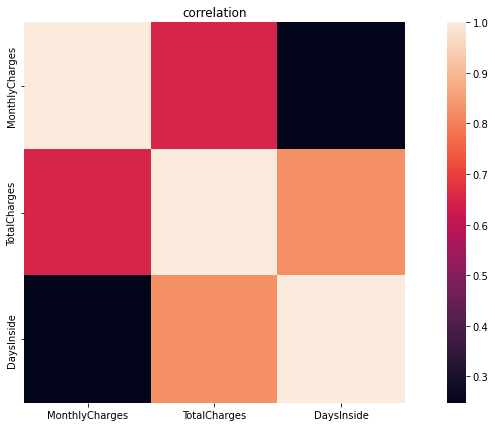

In [63]:
col = ['MonthlyCharges', 'TotalCharges', 'DaysInside']
cm = time[col].corr()
plt.figure(figsize=(15,7))
plt.title('correlation')
sns.heatmap(cm, square=True, fmt='.lf')
plt.show()

Удалим столбец года и месяца, чтобы избавиться от "временного" фактора в задаче классификации.

In [64]:
combine = combine.drop('Year', axis=1)
combine = combine.drop(columns=['Month'])

In [65]:
encoder = OrdinalEncoder()
col = ['gender', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'Day', 
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
       'StreamingTV', 'StreamingMovies', 'MultipleLines']
encoder.fit(time[col])
combine[col]=encoder.transform(time[col])
combine.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0.0,0,1.0,0.0,0.0,1.0,2.0,29.85,29.85,6.0,31,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0,0.0,0.0,1.0,0.0,3.0,56.95,1889.50,2.0,1036,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0,0.0,0.0,0.0,1.0,3.0,53.85,108.15,5.0,61,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0,0.0,0.0,1.0,0.0,0.0,42.30,1840.75,3.0,1371,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,1.0,2.0,70.70,151.65,3.0,61,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Масштабируем количественные признаки

In [66]:
scaled_features = combine.copy()
col_names = ['MonthlyCharges', 'TotalCharges', 'DaysInside']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
scaled_features.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Day,DaysInside,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0.0,0,1.0,0.0,0.0,1.0,2.0,-1.160323,-0.992611,6.0,-1.277527,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0,0.0,0.0,1.0,0.0,3.0,-0.259629,-0.172165,2.0,0.066892,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0,0.0,0.0,0.0,1.0,3.0,-0.362660,-0.958066,5.0,-1.237396,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0,0.0,0.0,1.0,0.0,0.0,-0.746535,-0.193672,3.0,0.515031,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,1.0,2.0,0.197365,-0.938874,3.0,-1.237396,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разделим данные на обучающую и тестовую выборки

In [67]:
x = scaled_features.drop('target', axis=1)
y = scaled_features['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Проверим разделение

In [68]:
len(x_train) + len(x_test) 

7043

### Модели машинного обучения

#### LogisticRegression

In [69]:
%%time
lr_model = LogisticRegression()
lr_score = cross_val_score(lr_model, x_train, y_train, cv = 5, scoring = make_scorer(accuracy_score))
lr_score = lr_score.mean()
lr_model = lr_model.fit(x_train, y_train)
predict = lr_model.predict(x_test)

probabilities_valid = lr_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]

lr_model_accuracy = accuracy_score(y_test, predict)
lr_model_roc_auc = roc_auc_score(y_test, probabilities_one_valid)

print('Средний Accuracy на тренировочной выборке' ,lr_score)
print("Accuracy на тестовой выборке", lr_model_accuracy)
print('----------------------------------')
print("ROC-AUC на тестовой выборке", lr_model_roc_auc)

Средний Accuracy на тренировочной выборке 0.8013858134187337
Accuracy на тестовой выборке 0.7927608232789212
----------------------------------
ROC-AUC на тестовой выборке 0.8204825001044147
CPU times: user 417 ms, sys: 351 ms, total: 768 ms
Wall time: 444 ms


Построим график Точности и Полноты

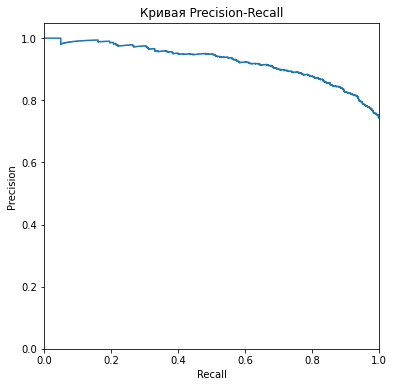

In [70]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

#### RandomForestClassifier

In [71]:
%%time
rfc = RandomForestClassifier()

best_model_forest = None
AUC_forest = 4000
best_est = 0
best_depth = 0
for est in range(1, 100, 5):
    for depth in range (1, 20, 5):
        model = RandomForestClassifier(random_state=12345, n_estimators=est ,max_depth=depth)
        AUC = cross_val_score(rfc, x_train, y_train, cv = 3, scoring=make_scorer(accuracy_score))

        AUC = AUC.mean()
        if AUC < AUC_forest:
            best_model_forest = model
            AUC_forest = AUC
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели:", AUC_forest, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Accuracy наилучшей модели: 0.8457578984735535 Количество деревьев: 26 Максимальная глубина: 16
CPU times: user 1min 59s, sys: 346 ms, total: 1min 59s
Wall time: 1min 59s


In [72]:
%%time
rfc = RandomForestClassifier(random_state=12345, n_estimators=66, max_depth=16)

rfc = rfc.fit(x_train, y_train)
predict = rfc.predict(x_test)

probabilities_valid = rfc.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]

rfc_accuracy = accuracy_score(y_test, predict)
rfc_roc_auc = roc_auc_score(y_test, probabilities_one_valid)

print("Accuracy на тестовой выборке", rfc_accuracy)
print('----------------------------------')
print("ROC-AUC на тестовой выборке", rfc_roc_auc)

Accuracy на тестовой выборке 0.8552164655784245
----------------------------------
ROC-AUC на тестовой выборке 0.8830360126132899
CPU times: user 481 ms, sys: 1.01 ms, total: 482 ms
Wall time: 482 ms


Построим график важности признаков для модели RandomForestClassifier

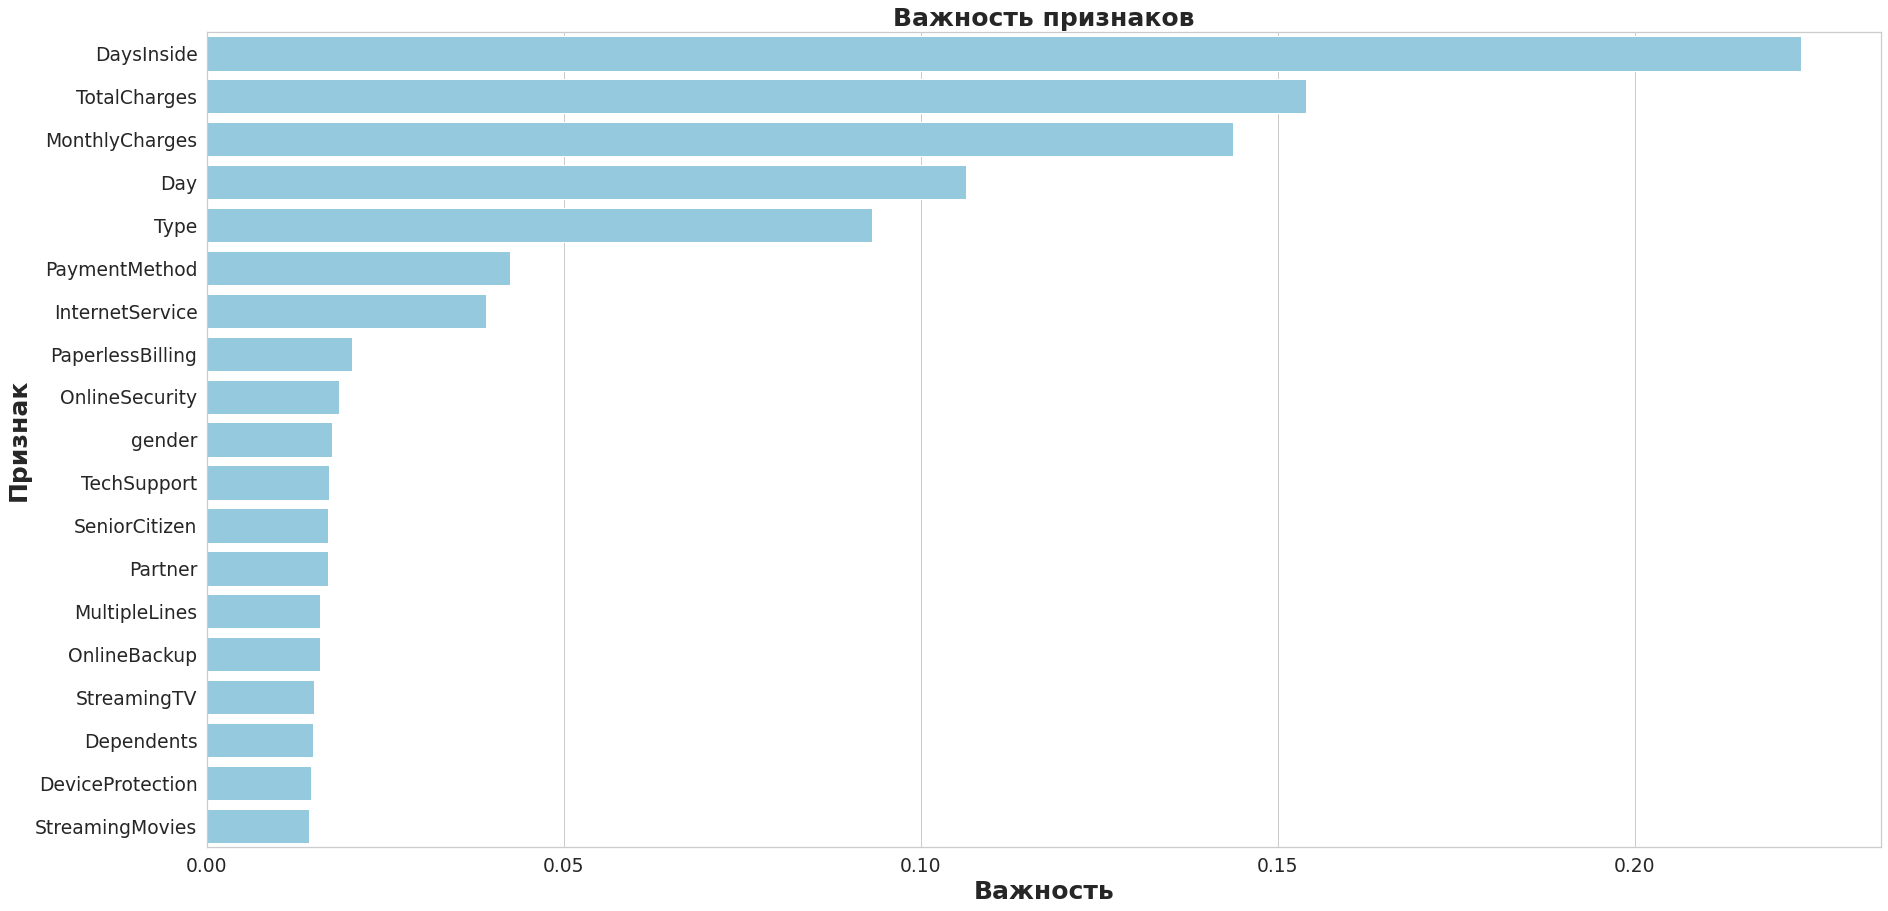

None

,Признак,Важность
0,DaysInside,0.223332
1,TotalCharges,0.153949
2,MonthlyCharges,0.143795
3,Day,0.106384
4,Type,0.093110
5,PaymentMethod,0.042387
6,InternetService,0.039035
7,PaperlessBilling,0.020350
8,OnlineSecurity,0.018490
9,gender,0.017574


In [73]:
feats = {}
for feature, importance in zip(x_train.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Важность'})
importances = importances.sort_values(by='Важность', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Признак'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Важность'], y=importances['Признак'], data=importances, color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признак', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Построим график Точности и Полноты

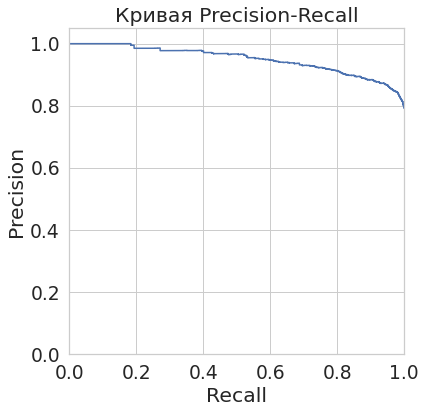

In [74]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

#### CatBoostClassifier

In [75]:
cbc = CatBoostClassifier(loss_function="Logloss", random_seed=12345,  iterations=150)
cbc = cbc.fit(x_train, y_train)
predict = cbc.predict(x_test)

probabilities_valid = cbc.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]

cbc_accuracy = accuracy_score(y_test, predict)
cbc_roc_auc = roc_auc_score(y_test, probabilities_one_valid)

print("Accuracy на тестовой выборке", cbc_accuracy)
print('----------------------------------')
print("ROC-AUC на тестовой выборке", cbc_roc_auc)

Learning rate set to 0.12276
0:	learn: 0.6412349	total: 50.1ms	remaining: 7.47s
1:	learn: 0.6032354	total: 52.1ms	remaining: 3.86s
2:	learn: 0.5722302	total: 54.1ms	remaining: 2.65s
3:	learn: 0.5383283	total: 56.2ms	remaining: 2.05s
4:	learn: 0.5104045	total: 58.4ms	remaining: 1.69s
5:	learn: 0.4908969	total: 60.5ms	remaining: 1.45s
6:	learn: 0.4771805	total: 62.7ms	remaining: 1.28s
7:	learn: 0.4605133	total: 64.7ms	remaining: 1.15s
8:	learn: 0.4453991	total: 66.9ms	remaining: 1.05s
9:	learn: 0.4329855	total: 68.8ms	remaining: 963ms
10:	learn: 0.4224119	total: 70.8ms	remaining: 895ms
11:	learn: 0.4154873	total: 73.2ms	remaining: 842ms
12:	learn: 0.4065192	total: 75.5ms	remaining: 795ms
13:	learn: 0.4006524	total: 77.7ms	remaining: 755ms
14:	learn: 0.3955632	total: 79.9ms	remaining: 719ms
15:	learn: 0.3912730	total: 82.2ms	remaining: 688ms
16:	learn: 0.3839844	total: 84.5ms	remaining: 661ms
17:	learn: 0.3805011	total: 86.7ms	remaining: 636ms
18:	learn: 0.3747262	total: 89ms	remaining: 6

Построим график важности признаков для CatBoostClassifier

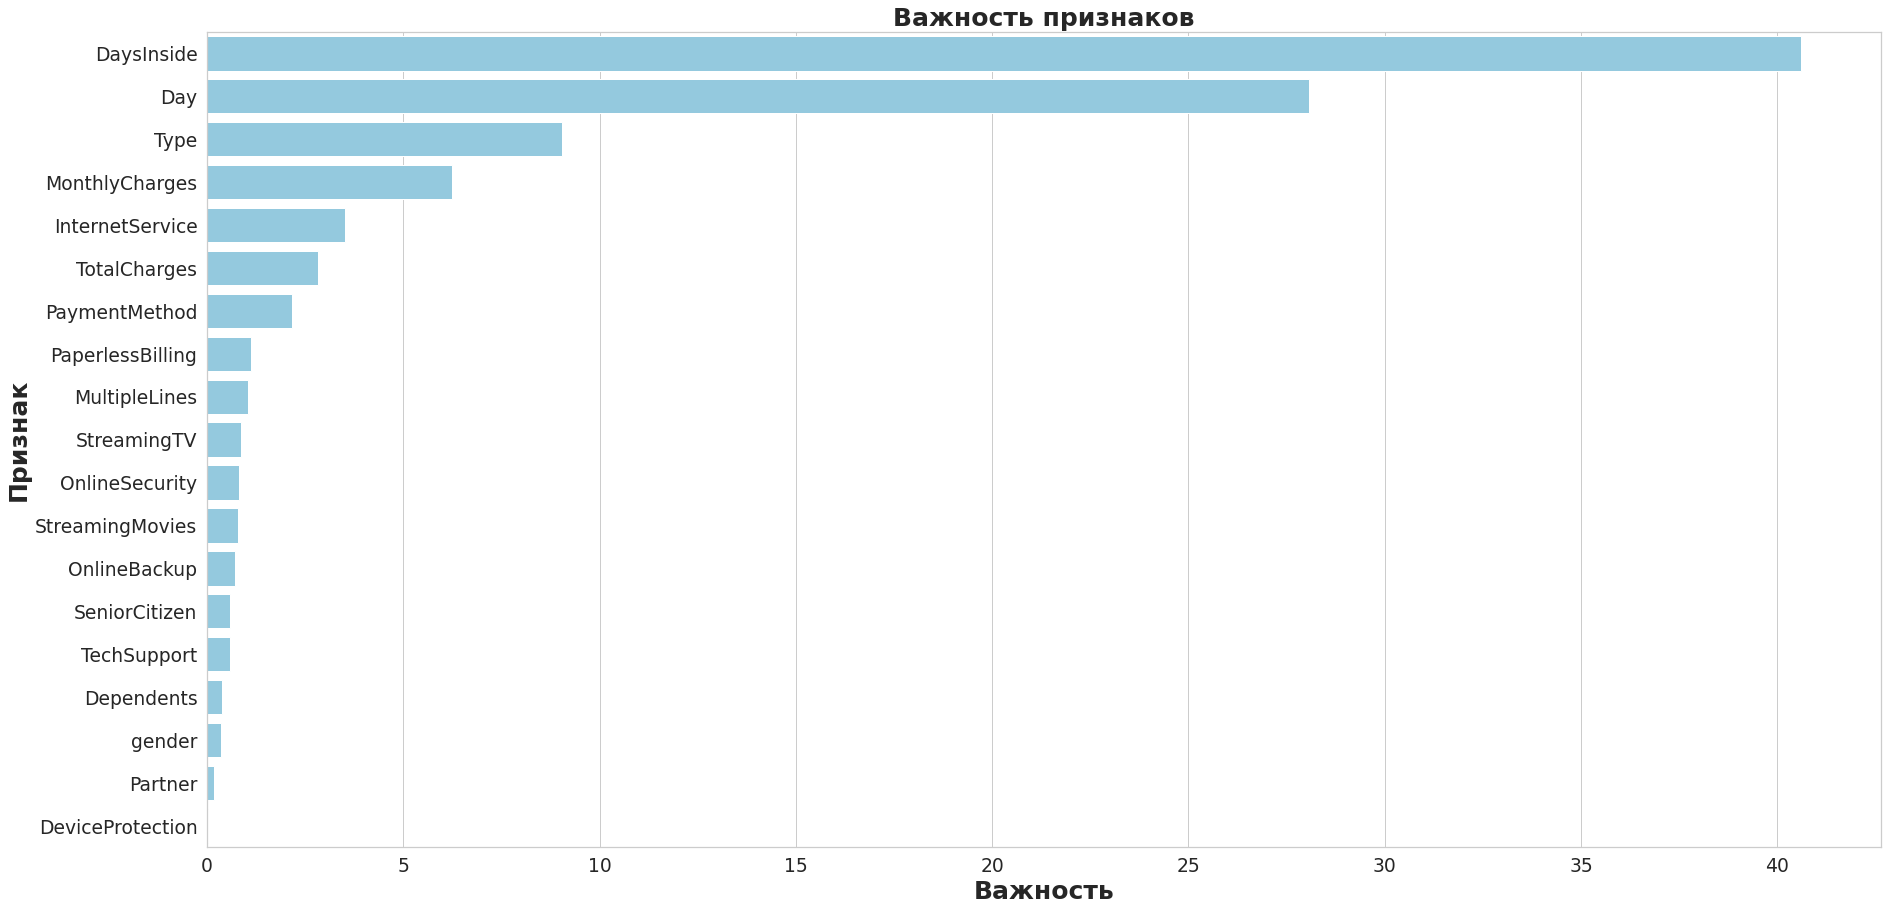

None

,Признак,Важность
0,DaysInside,40.610563
1,Day,28.084620
2,Type,9.046605
3,MonthlyCharges,6.235945
4,InternetService,3.517871
5,TotalCharges,2.833489
6,PaymentMethod,2.169169
7,PaperlessBilling,1.122002
8,MultipleLines,1.046708
9,StreamingTV,0.878736


In [76]:
feats = {}
for feature, importance in zip(x_train.columns, cbc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Важность'})
importances = importances.sort_values(by='Важность', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Признак'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Важность'], y=importances['Признак'], data=importances, color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признак', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Построим график Точности и Полноты

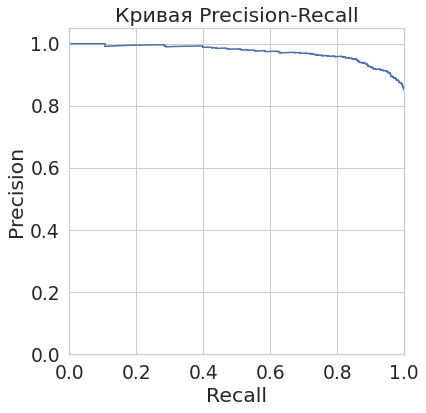

In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

In [78]:
models = pd.DataFrame({
    'Модель': ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'], 
    'Accuracy': [lr_model_accuracy  , rfc_accuracy  , cbc_accuracy],
    'ROC_AUC': [lr_model_roc_auc, rfc_roc_auc, cbc_roc_auc]

})
models

,Модель,Accuracy,ROC_AUC
0,LogisticRegression,0.792761,0.820483
1,RandomForestClassifier,0.855216,0.883036
2,CatBoostClassifier,0.890703,0.936662


<a id='section_9'></a>

### Выводы

В данном проекте мы исследовали данные телеком компании. Данные были подготовлены к машинному обучению, далее были созданы модели машинного обучения для предсказания оттока клиентов. 

1. <b>Произведена проверка зависимости в оплатах признаков:</b> Услуга интернет, гендерное разделение, возрастное разделение, наличие детей и метод оплаты.
* <b>Интернет.</b>
Fiber optic используют 62% представленных людей, они же и тратят в месяц больше остальных, в среднем - 91уе

* <b>Гендерное разделение.</b>
Нам представлен датасет, в котором почти поровну мужчин и женщин.
Интересно то, что в месячной оплате между мужчинами и женщинами нет видимой разницы в данных. Они в среднем одинаково платят в месяц по 65 и 64 уе. По итогу была проверена гипотеза, ставящая вопрос одинакова ли средняя месячная оплата мужчин и женщин. За нулевую гипотезу приняти то , что они одинаковы, а за альтернативную то, что они отличаются. Предположения оказались верны. Не вышло опровергнуть нулевую гипотезу о том, что платеж мужчины и женщины одинаковый. Можно сделать заключение, что касательно средней месячной оплаты значимой статистической разницы в гендере клиента нет.
* <b>Возрастное разделение.</b>
Пенсионеров в данных почти 20%. Что интересно, в среднем пенсионеры платят больше, чем другие группы людей - около 80 уе. Видимо, это связано с большим количеством услуг, на которые люди соглашаются при подключении и в силу возраста не могут потом отключить.
* <b>Наличие детей.</b>
Людей, у торорых детей нет, в датасете 72% и платят они в месяц в среднем 67уе. Люди у которых дети есть платят меньше - 59уе. Вероятно, наличие детей налагает свой отпечаток на бюджете семьи и факторе экономии.
* <b>Метод оплаты.</b>
Наибольшее количество людей используют электронный чек при оплате - почти 40%. Они же в среднем платят больше других 76уе в месяц. Может быть эти люди "продвинутее" остальных.

2. <b>Были построены 3 модели машинного обучения:</b> LogisticRegression, RandomForestClassifier, CatBoostClassifier. Основной метрикой явилась AUC-ROC, дополнительной - Accuracy.
Наилучшие предсказания произвела модель CatBoostClassifier. Данные по моделям машинного обучения приложены в сводной таблице ниже.

In [79]:
models

,Модель,Accuracy,ROC_AUC
0,LogisticRegression,0.792761,0.820483
1,RandomForestClassifier,0.855216,0.883036
2,CatBoostClassifier,0.890703,0.936662


------------------------------------

## Отчет о проделанной работе.

В проделанной работе были с успехом выполнены все пункты плана

* [x] Загрузка данных
* [x] Общая информация
* [x] Подготовка данных
* [x] Соединие таблиц
* [x] Исследовательский анализ данных
* [x] Проверка гипотез
* [x] Подготовка данных к машинному обучению
* [x] Модели машинного обучения
* [x] Выводы

* К ключемым шагам в решении проекта я бы отметил качественный анализ данных (это позволяет лучше понять суть проблемы заказчика), соединение таблиц (объединить все данные в один датасет и увидеть всю картину целиком), подбор модели машинного обучения, которая лучше всего решит поставленную задачу.

* Лучших показателей удалось добиться с моделью машинного обучения CatBoostClassifier с показателем качества AUC-ROC 0.943877.